# Calculating NDVI from Landsat 8 imagery without a GIS

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) is a simple indicator that can be used to assess whether the target, usually a remotely-sensed raster image, contains live green vegetation.  This calculation uses two bands of a remote dataset, the Red and Near-Infrared (NIR) bands.

\begin{align}
NDVI & = \frac{(NIR - Red)}{(NIR + Red)}
\end{align}

For this tutorial, we'll use the NIR and Red bands from a landsat 8 scene above part of the central valley and the Sierra Nevada in California.  We'll be using [Level 1 datasets](https://landsat.usgs.gov/landsat-processing-details), orthorectified, map-projected images containing radiometrically calibrated data. These images can be individually downloaded from a variety of sources including:

* [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (Account required for download)
* [Amazon AWS](https://aws.amazon.com/public-datasets/landsat/)
* [Development Seed "Libra"](https://libra.developmentseed.org)

The specific scene we'll be using is `LC08_L1TP_042034_20170616_20170629_01_T1`, which can be downloaded from AWS at https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1.  Note that this is an index page that links to the scene's rasters, not the dataset itself.

More information on Landsat collections here: [https://landsat.usgs.gov/landsat-collections](https://landsat.usgs.gov/landsat-collections)

![Preview of our landsat 8 scene](http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_thumb_small.jpg)

### Bands

* Red: Band 4 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B4.TIF``)
* Near-Infrared: Band 5 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B5.TIF``)

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files.  Some other rasters may store multiple bands in the same file.

In [1]:
%matplotlib inline

import rasterio
from matplotlib import pyplot as plt
import numpy

SCENE = 'LC08_L1TP_042034_20170616_20170629_01_T1'
AWS_URL = f'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/{SCENE}'
RED_BAND = f'{AWS_URL}/{SCENE}_B4.TIF'
NIR_BAND = f'{AWS_URL}/{SCENE}_B5.TIF'


def plot(array, label=None):
    """Plot a numpy array with a colorbar."""
    plt.imshow(array)
    plt.colorbar()
    if label is None:
        label = 'Raster {}'.format(array.shape)
    plt.title(label)
    plt.xlabel('Column #')
    plt.ylabel('Row #')

In [4]:
import pprint
with rasterio.open(RED_BAND) as raster:
        pprint.pprint(raster.meta) # raster.profile

{'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7951,
 'nodata': None,
 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0),
 'width': 7821}


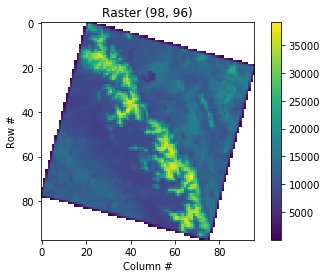

In [7]:
with rasterio.open(RED_BAND) as raster:
    # matrix = raster.read(1) # band 1
    overviews = raster.overviews(1) #band 1
    smallest_overview = overviews[-1]
    
    thumbnail = raster.read(1, out_shape=(1, raster.height// smallest_overview, raster.width// smallest_overview))
    
    thumbnail = thumbnail.astype(numpy.float)
    thumbnail[thumbnail ==0] = numpy.NaN
    plot(thumbnail)
    
    # out_shape first parameter 1 is 

In [ ]:
help(raster.read)

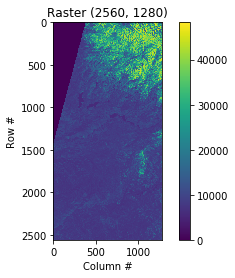

In [9]:
# subset a raster

import rasterio.windows
with rasterio.open(RED_BAND) as raster:
    subset = raster.read(1, window=rasterio.windows.Window(1024, 1024, 1280, 2560)) # indices of rows and columns
    plot(subset)

In [15]:
from rasterio import Affine

with rasterio.open(RED_BAND) as raster:
    transform = raster.transform
    pprint.pprint(transform)
    pprint.pprint(transform * Affine.scale(9,9))

Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0)
Affine(270.0, 0.0, 204285.0,
       0.0, -270.0, 4268115.0)


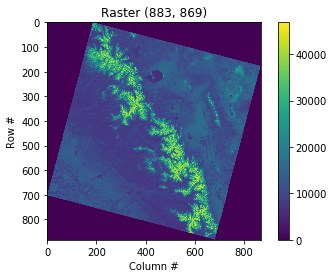

In [21]:
# write a decimated raster to disk

with rasterio.open(RED_BAND) as raster:
    profile = raster.meta.copy() #raster.profile
    
    oview_factor = raster.overviews(1)[1]
    pixel_values = raster.read(1, out_shape=(1, raster.height // oview_factor, raster.width// oview_factor))
    
    profile.update({
        'dtype' : 'float32',
        'height': raster.height// oview_factor,
        'width' : raster.width// oview_factor,
        'transform' : raster.transform * Affine.scale(9,9)
    })
    
    with rasterio.open('red_downsized.tif','w',**profile) as dest_raster:
        dest_raster.write(pixel_values.astype(rasterio.float32),1)
        
with rasterio.open('red_downsized.tif') as raster:
    plot(raster.read(1))